In [25]:
%load_ext autoreload
%autoreload 2

from model.autoregressive import ARModel
from model.lorenz96 import Lorenz96
from model.parameter import Parameter
from filtering.colkf import ColKF
from filtering.enkf import EnKF
from utils import default_generator
from utils.plotter import Plotter
from utils.compare import Comparator

import numpy as np
import matplotlib.pyplot as plt

Plotter.fig_folder = "cover-L96"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
generator = default_generator
F = 4
forcing = Parameter(init_value=F, uncertainty=1, name="$F$", estimate=False)
D = 20

dt = 0.04
T0 = 0
T = 7
N = 80

x0_unperturbed = generator.normal(size=D)
x0 = x0_unperturbed.copy()
x0 += 1

Q_0 = 0.5 * np.eye(D)
Q_x = lambda _: 0.5 * np.eye(D)
R = lambda _: 0.05 * np.eye(D)

b0 = np.zeros(D)
b0_cov = 0.1 * np.eye(D)
Q_b = lambda _: 0.001 * np.eye(D)
b_true = 0.3 * np.ones(D)

H = lambda _: np.eye(D)

model = Lorenz96(
    x0_unperturbed,
    dt,
    D,
    forcing,
    H,
    Q_x,
    R,
    generator,
    solver="rk4",
    stochastic_integration=False,
    stochastic_propagation=False,
)

model.discrete_forcing = lambda *_: b_true
times, states = model.integrate(T0, T)
model.reset_model(x0)

# Generate observations with noise
assimilation_step = 0.5
assimilation_times = np.linspace(assimilation_step, T, int(T / assimilation_step))
observed = np.zeros((D, len(assimilation_times)))
for i, t in enumerate(assimilation_times):
    k = int(t / dt)
    observed[:, i] = model.observe(states[:, k], add_noise=True)

In [27]:
model.discrete_forcing = lambda *_: np.zeros(D)
model.stochastic_propagation = True

enkf = EnKF(model, x0, Q_0, N, generator=generator, loc_radius=3)
results = enkf.filter(assimilation_times, observed)
results.true_times = times
results.true_states = states
results.figsize = "horizontal"

  0%|          | 0/14 [00:00<?, ?it/s]

100%|██████████| 14/14 [00:01<00:00,  9.11it/s]

Localize: True


In [28]:
A = lambda _: np.diag([1] * D)
H_ar = lambda _: np.zeros((0, b0.shape[0]))

enkf.model.system_cov = lambda _: 0.05 * np.eye(D)
ar_model = ARModel(
    A,
    H_ar,
    b0,
    dt,
    Q_b,
    generator,
    stochastic_propagation=False,
    stochastic_integration=True,
)
colkf = ColKF(ar_model, enkf, x0, Q_0, b0, b0_cov, feedback=True)
colkf.filter_obj.loc_radius = 3
results_col = colkf.filter(assimilation_times, observed)
results_col.figsize = "horizontal"

100%|██████████| 14/14 [00:03<00:00,  3.91it/s]

Localize: True


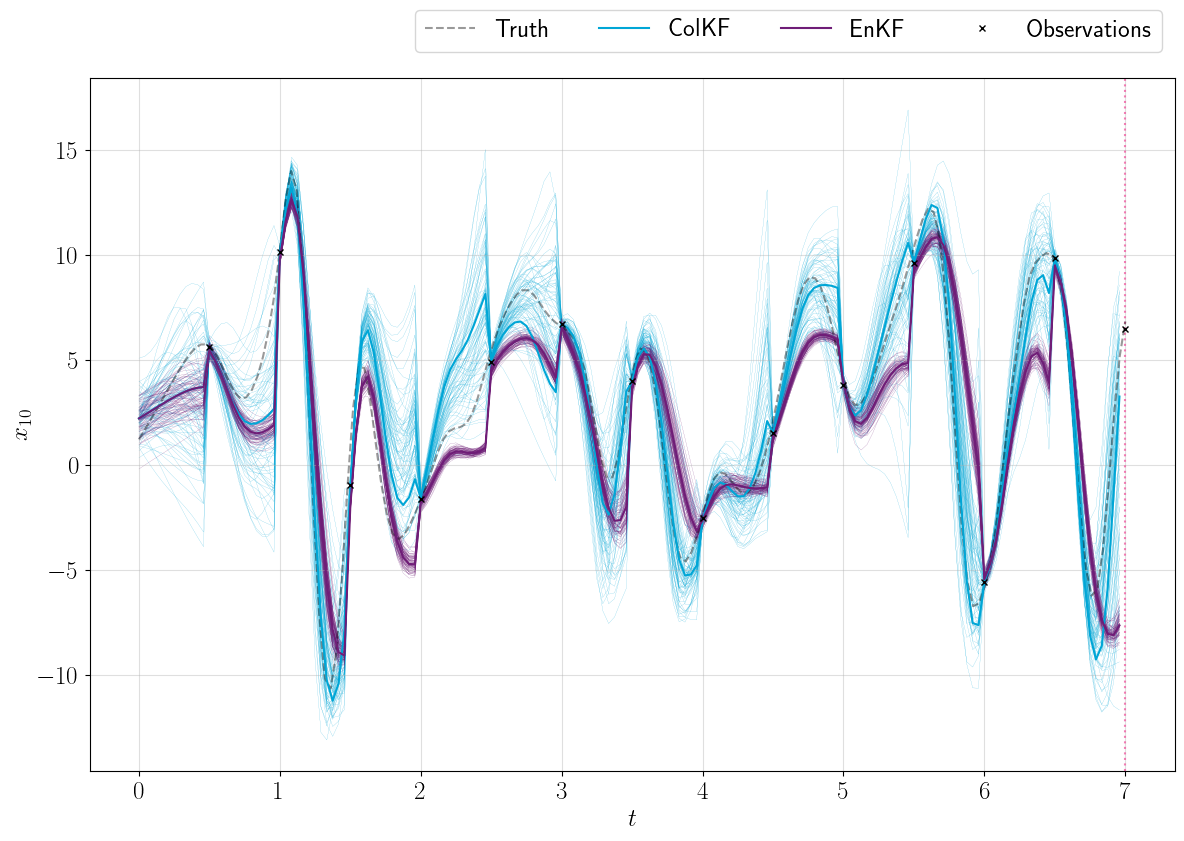

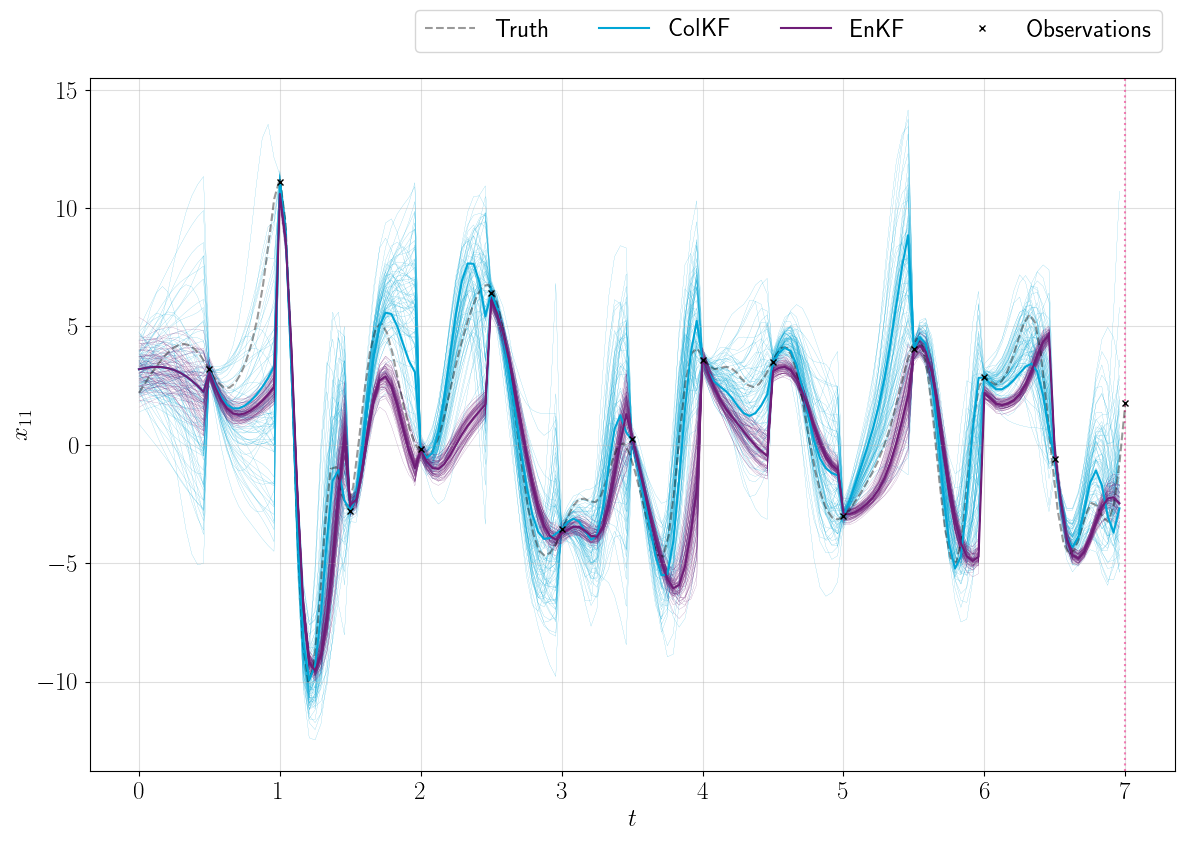

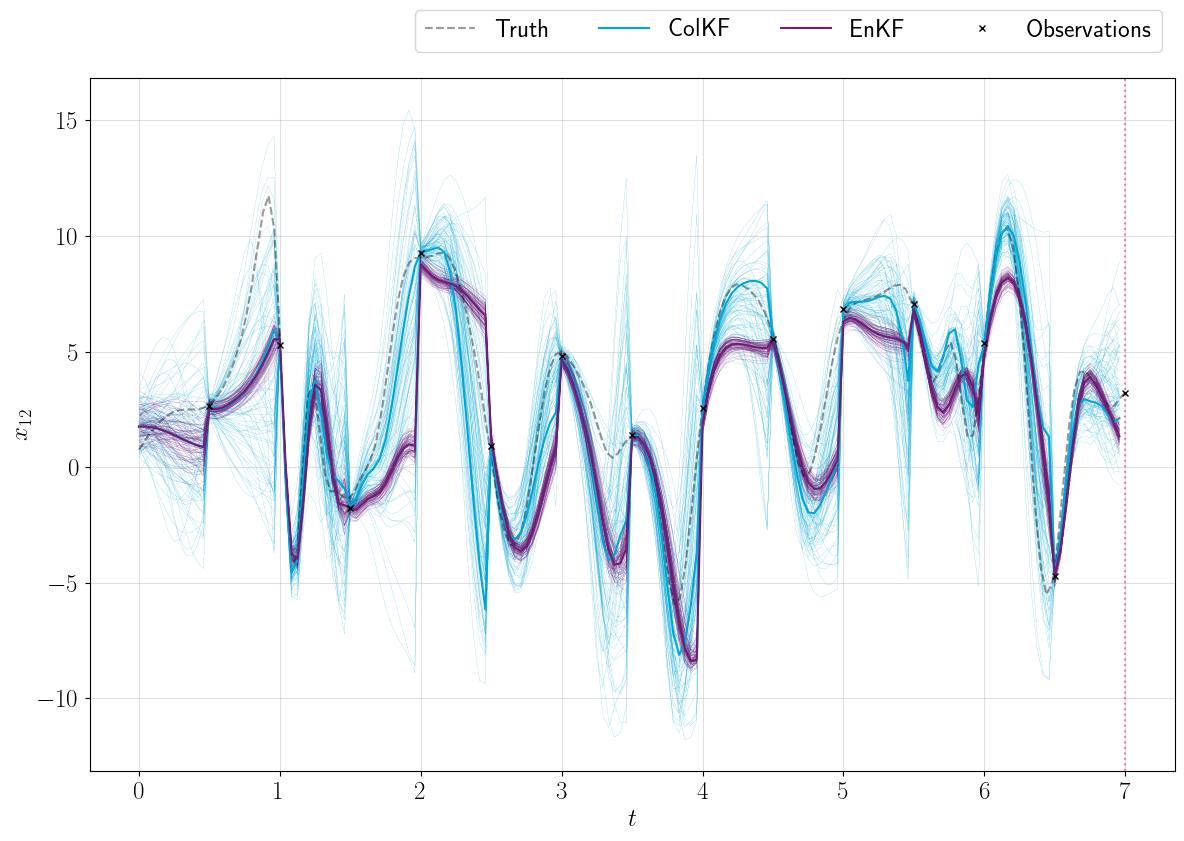

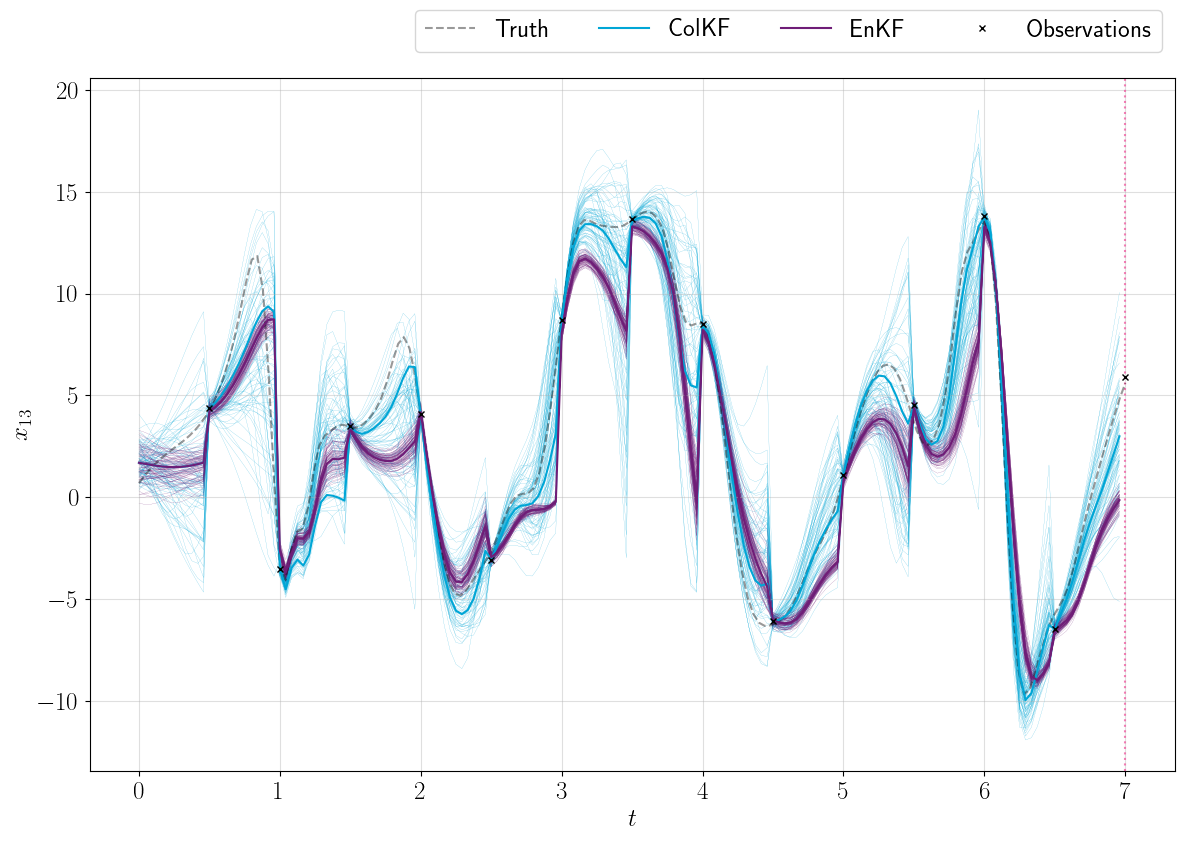

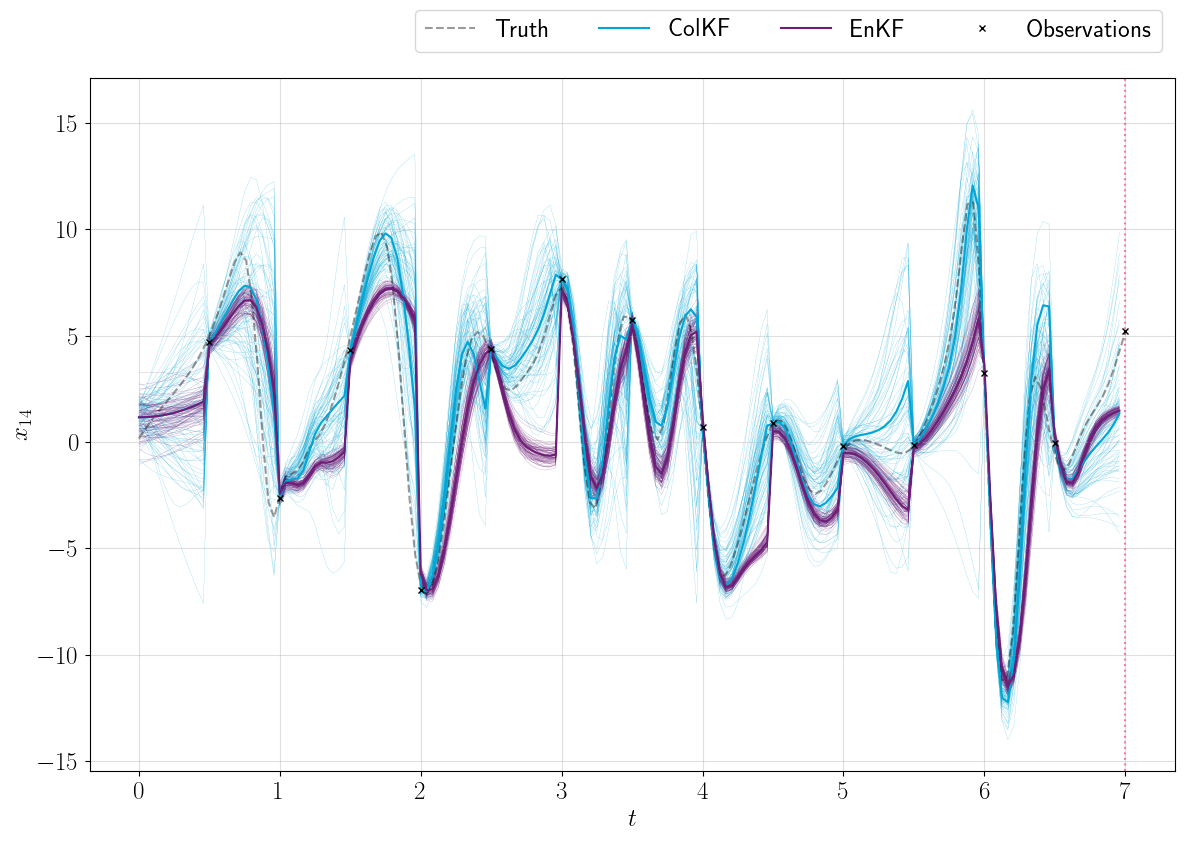

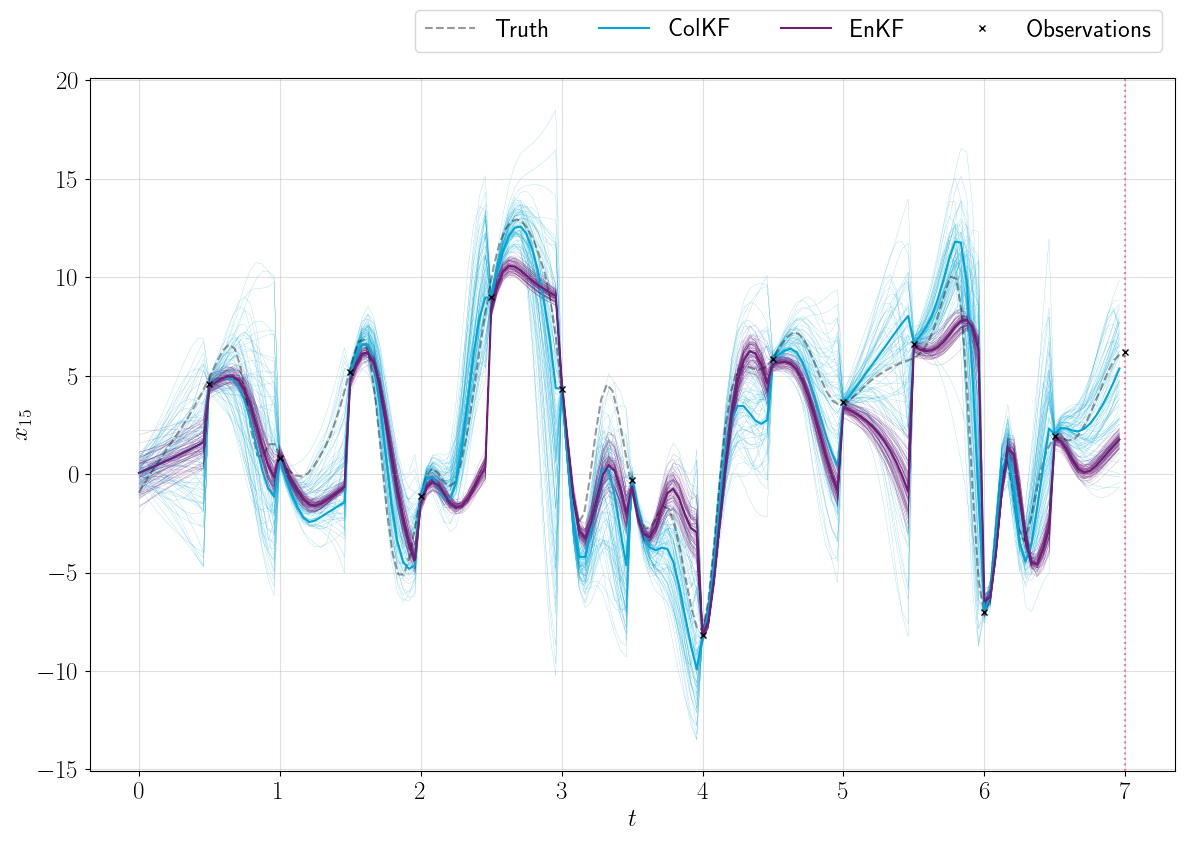

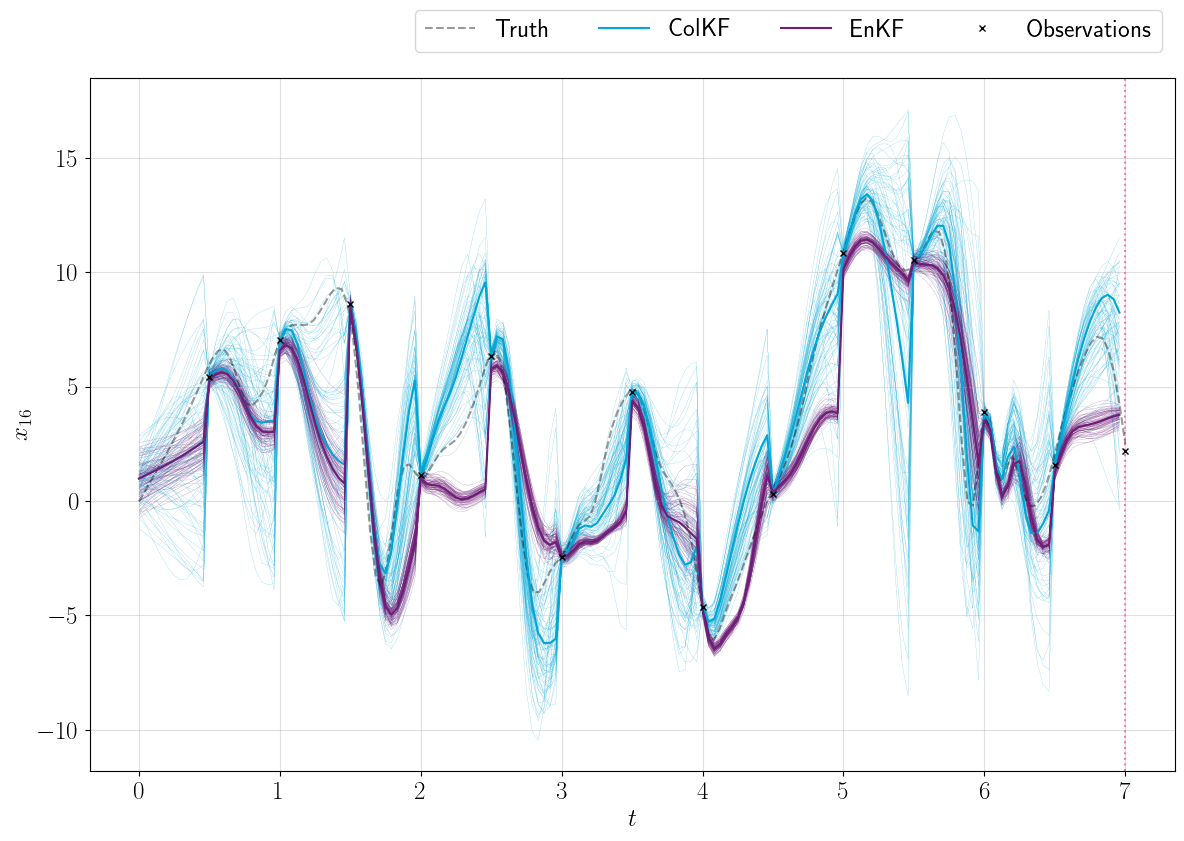

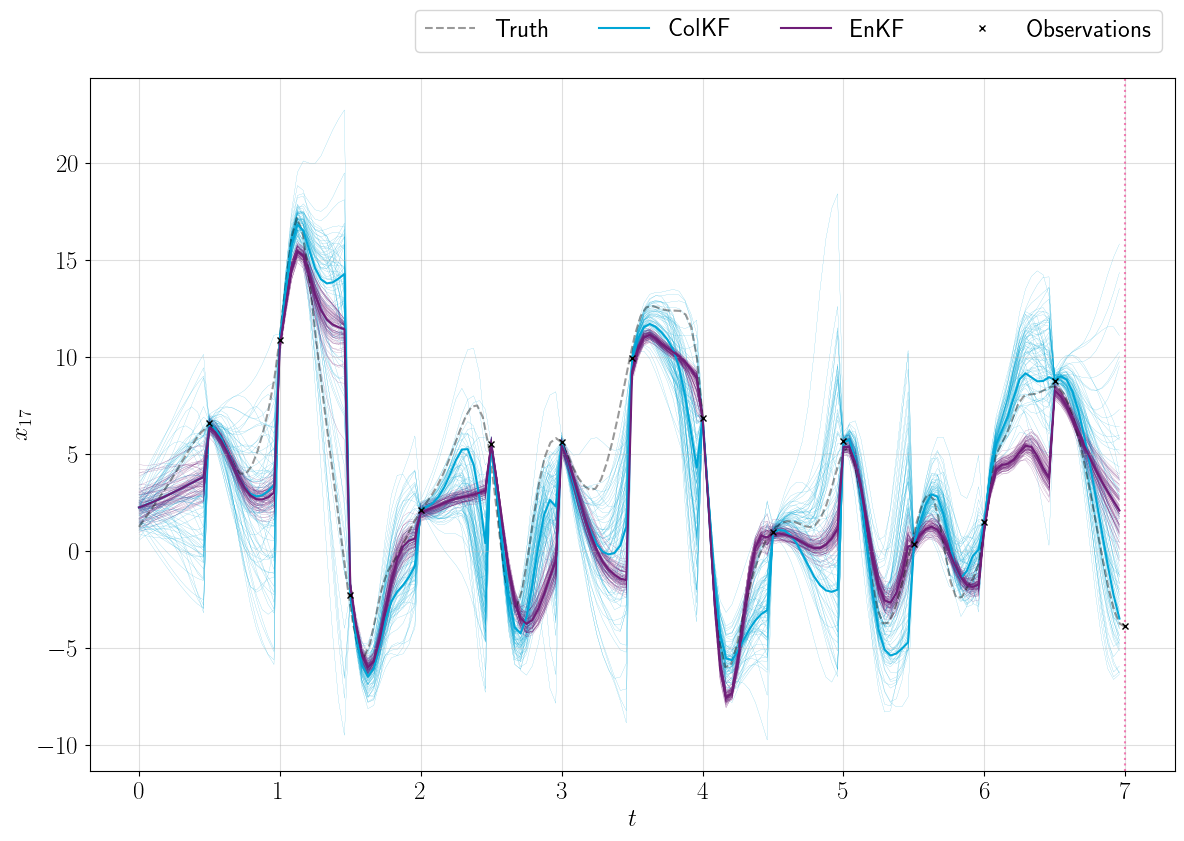

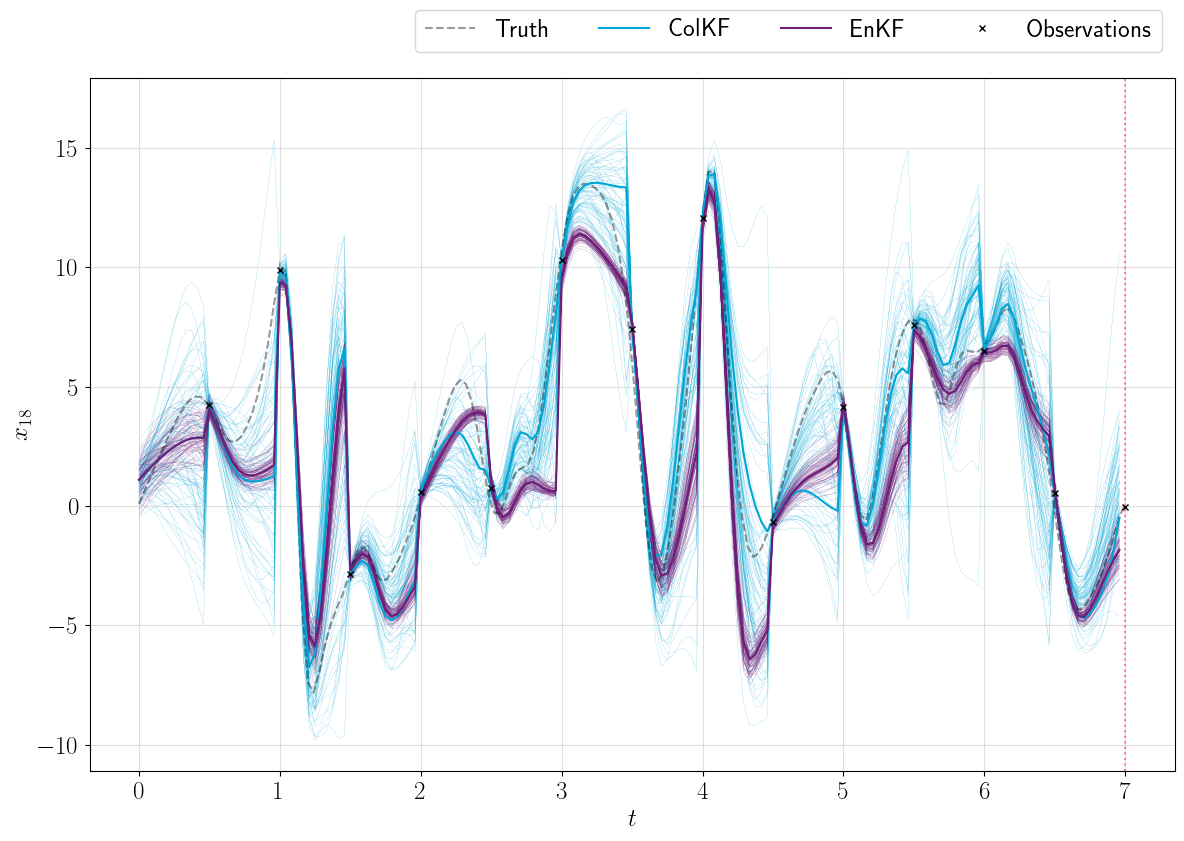

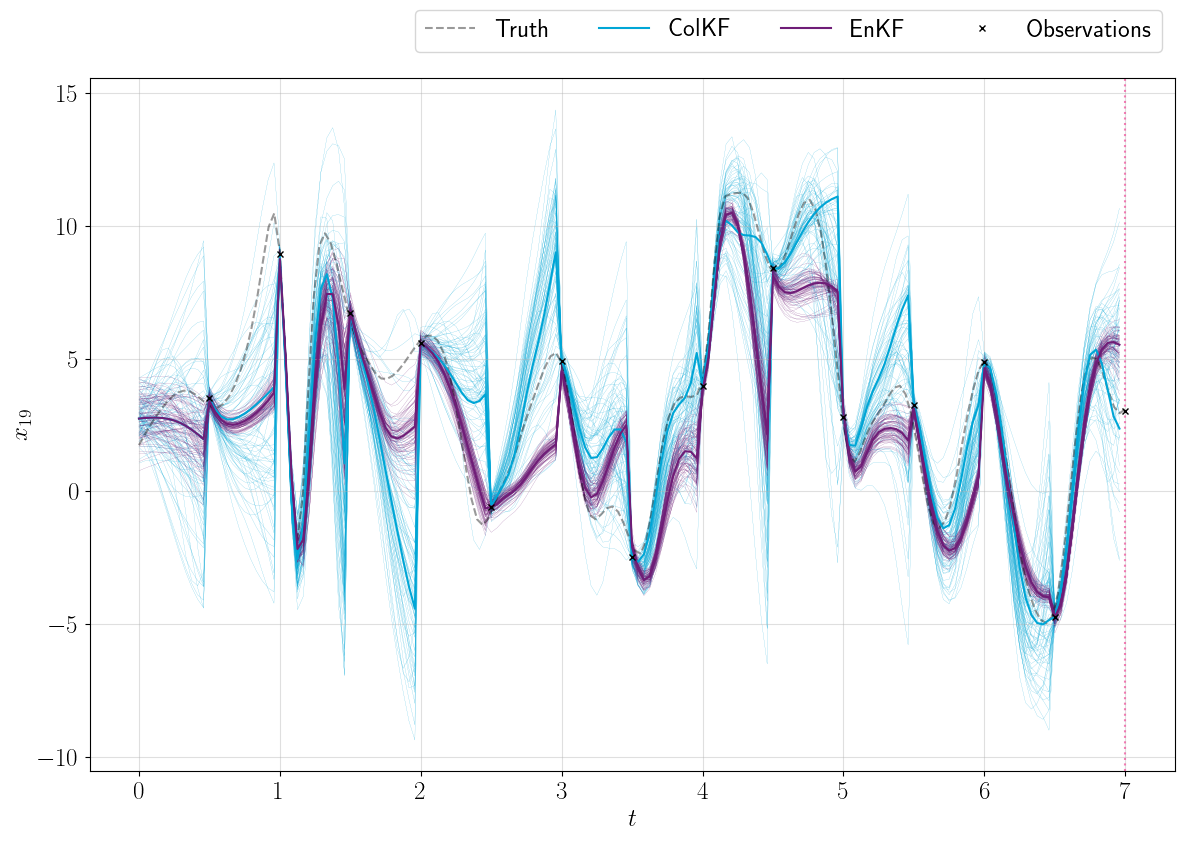

In [29]:
c = Comparator([results_col, results], ["ColKF", "EnKF"])
Plotter.ensemble_alpha: float = 1
Plotter.ensemble_width: float = 0.1
# Plotter.ensemble_alpha = 0.3
# Plotter.ensemble_width = 0.05
idxs = range(10, D)
# idxs = [0]
for i in idxs:
    c.compare_filtering(
        state_idx=i,
        plot_ensemble=True,
        plot_bands=False,
        figsize="vertical",
        path=f"compare_x{i}",
    )
    # c.compare_innovations(
    #     state_idx=i, figsize="horizontal", window=3, path=f"compare_inn_x{i}"
    # )
plt.show()

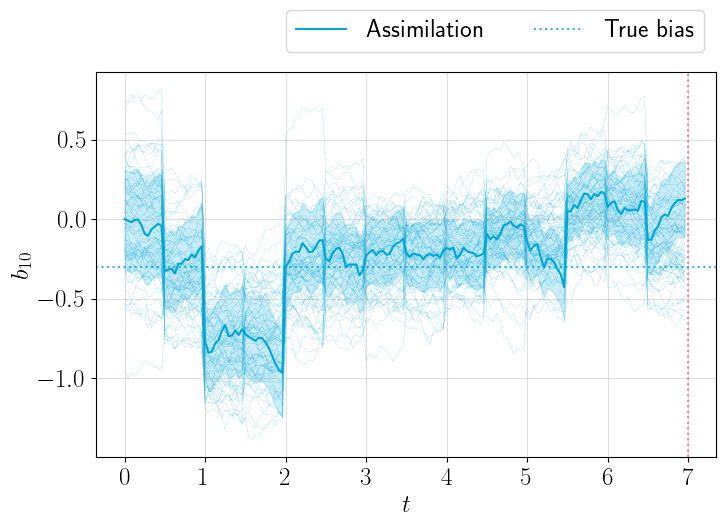

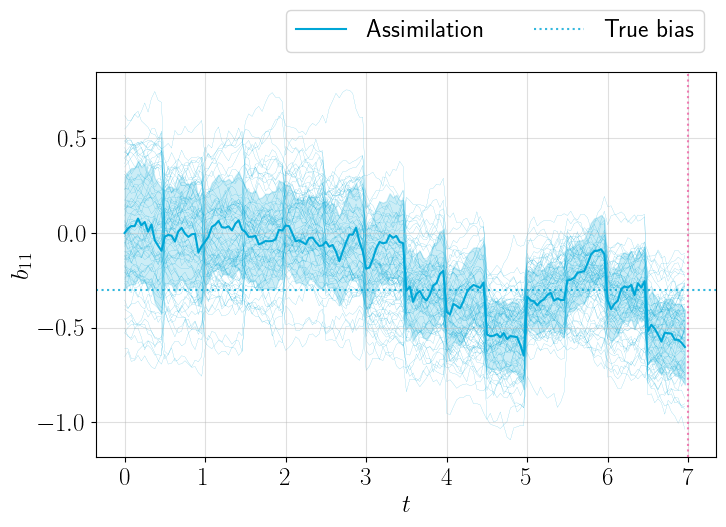

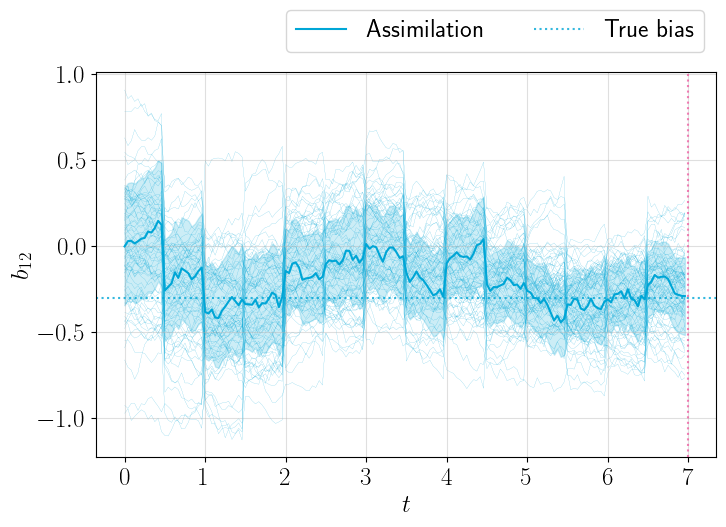

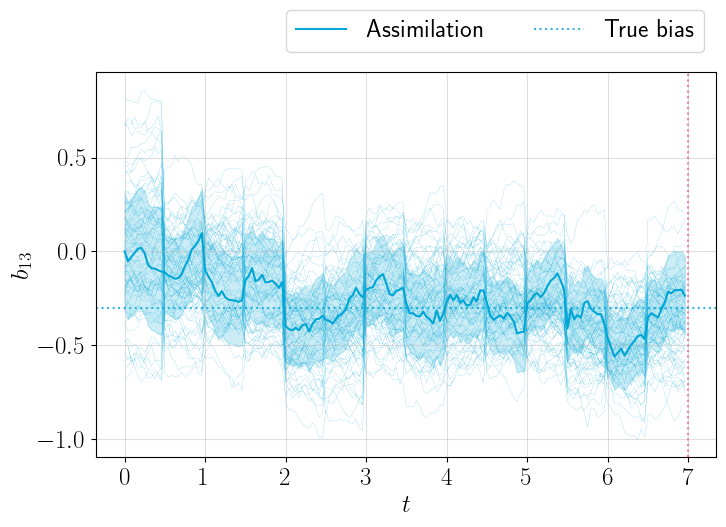

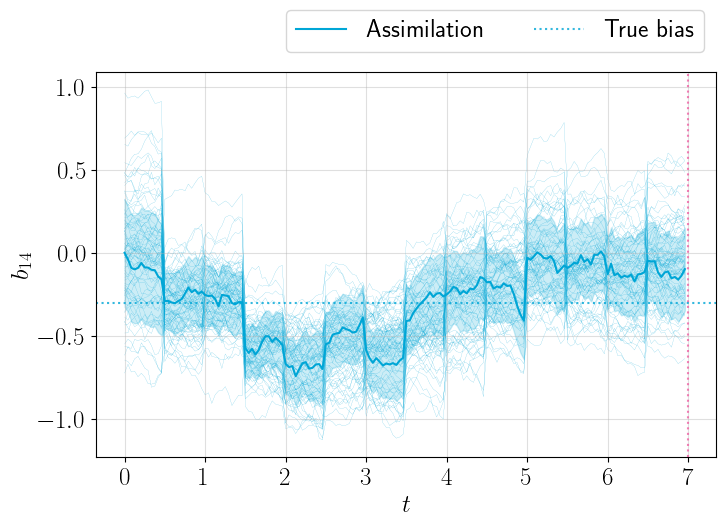

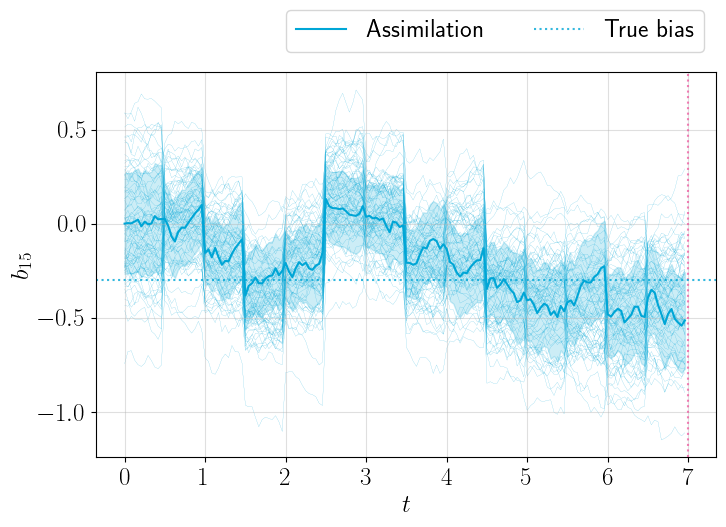

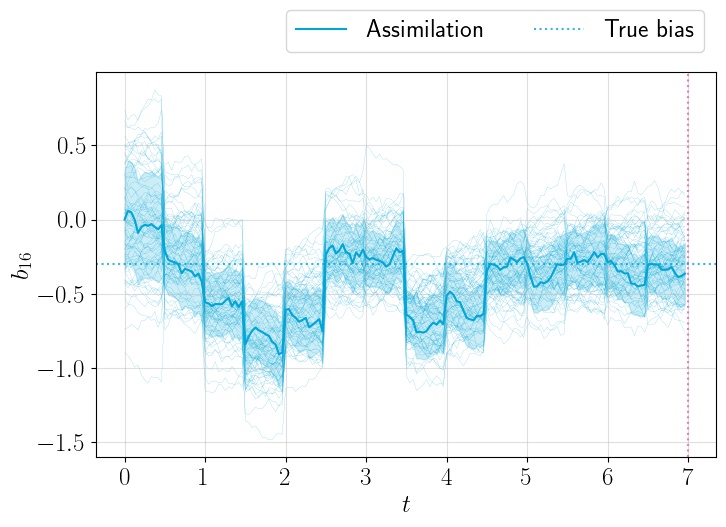

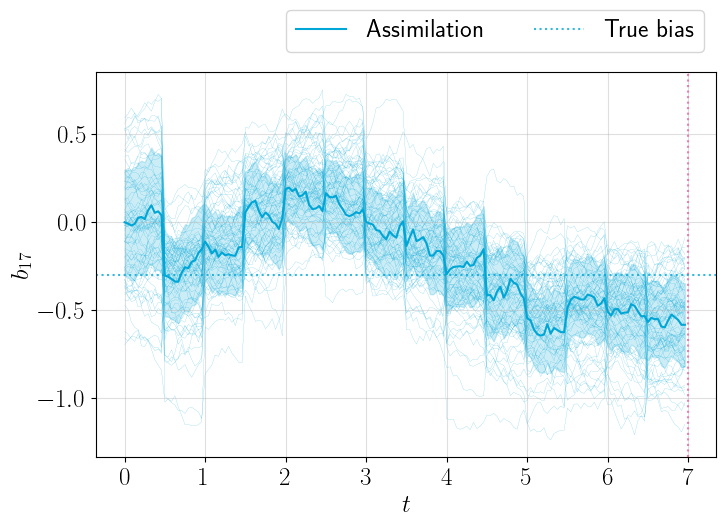

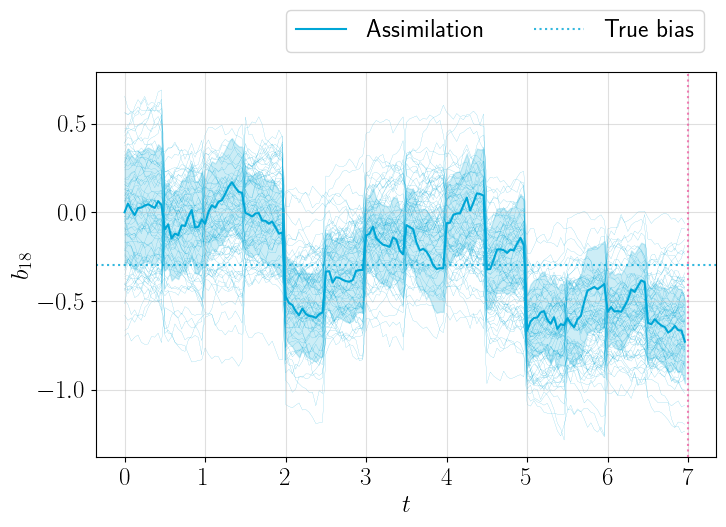

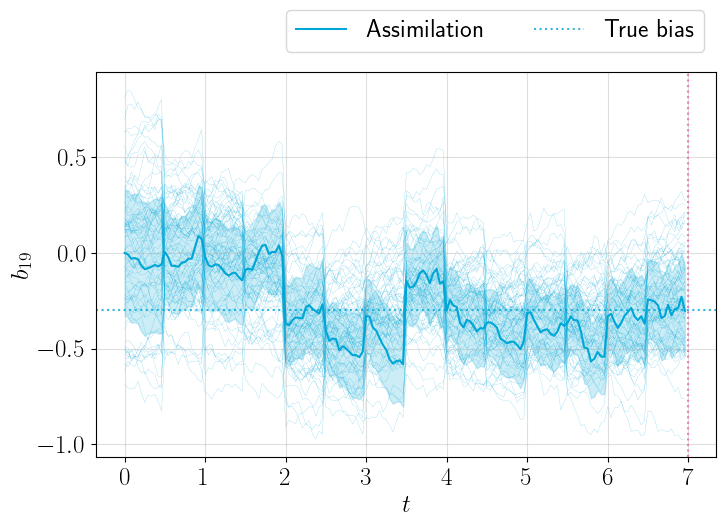

In [30]:
for j, i in enumerate([s + D for s in idxs]):
    results_col.figsize = "standard"
    ax = results_col.plot_filtering(i, True, True, only_state=True)
    Plotter.hline(
        -b_true[j], ax=ax, color=Plotter.color, label="True bias", path=f"bias_ar{i-D}"
    )

<Axes: xlabel='Average innovations per state', ylabel='Frequency'>

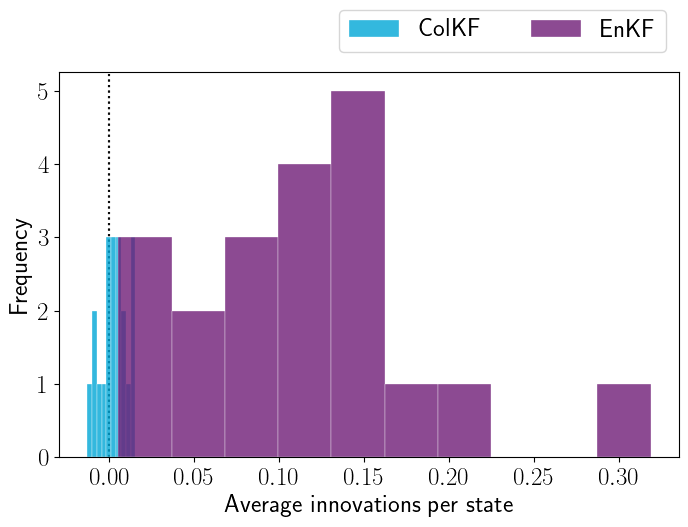

In [31]:
c.compare_av_innovations(alpha=0.8, path="av_inn")

In [32]:
if forcing.estimate:
    ax = results.plot_params([0], [F])
    results_col.plot_params([0], [F], ax=ax)